# Strike-Dip-Rake to $S_{ij}$
> By J.N. Hayek (25.10.2022)
* The problem is that is not straightforward to figure out the input parameters of the homogeneous optimal stress field.
* Now, it would be useful to derive the stress tensor out of the input parameters of the optimal stress mapping used by seissol.
    * For this I could just translate the evaluation algorithm used in easi to do such mapping.
* After having this function, I could just import the fault geometry mesh and calculate the strike direction, dip direction, and normal direction per face
* To map the parameter space, one could use an MCMC method to find the strike-dip-rake variables that minimizes the differences between the slip derived kinematic stress offset and the localization of overstressed patches on the fault


In [1]:
import os
import numpy as np

import pyvista as pv
import seissolxdmf as seisx

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from palettable.scientific import diverging as cmapa #Palettable colormaps, can be removed

import meshio
from Module.GeneralUtils import *


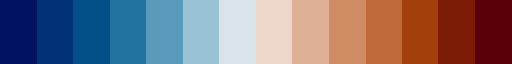

In [2]:
from matplotlib.colors import ListedColormap
Cmap = ListedColormap(cmapa.Vik_14.mpl_colors)
Cmap

### Function definition

In [3]:
def OptimalStress(strike, dip, rake, Mo=1):
    strike_rad = strike * np.pi / 180.0
    dip_rad    = dip * np.pi / 180.0
    rake_rad   = rake * np.pi / 180.0

    Mxx = -Mo*( np.sin(dip_rad)*np.cos(rake_rad)*np.sin(2*strike_rad) + np.sin(2*dip_rad)    *np.sin(rake_rad)*np.sin(strike_rad)^2 )
    Mxy =  Mo*( np.sin(dip_rad)*np.cos(rake_rad)*np.cos(2*strike_rad) + 0.5*np.sin(2*dip_rad)*np.sin(rake_rad)*np.sin(2*strike_rad) )
    Mxz = -Mo*( np.cos(dip_rad)*np.cos(rake_rad)*np.cos(strike_rad)   + np.cos(2*dip_rad)    *np.sin(rake_rad)*np.sin(strike_rad) )
    Myy =  Mo*( np.sin(dip_rad)*np.cos(rake_rad)*np.sin(2*strike_rad) - np.sin(2*dip_rad)    *np.sin(rake_rad)*np.cos(strike_rad)^2 )
    Myz = -Mo*( np.cos(dip_rad)*np.cos(rake_rad)*np.sin(strike_rad)   - np.cos(2*dip_rad)    *np.sin(rake_rad)*np.cos(strike_rad) )
    Mzz =  Mo*( np.sin(2*dip_rad)*np.sin(rake_rad) )

    return [Mxx, Mxy, Mxz, Myy, Myz, Mzz]


def OptimalStressEasi(strike, dip, rake, mu_s, mu_d, R, s2ratio, cohesion, effectiveConfiningStress):    
    # Taken from: https://github.com/SeisSol/easi/blob/master/src/component/OptimalStress.cpp
    
    Phi = np.pi / 4.0 - 0.5 * np.arctan(mu_s) #is the equivalent to c++ tan a np.arctan or np.arctan2?

    strike_rad = strike * np.pi / 180.0
    dip_rad = dip * np.pi / 180.0
    rake_rad = rake * np.pi / 180.0

    s2 = np.sin(2.0 * Phi)
    c2 = np.cos(2.0 * Phi)
    alpha = (2.0 * s2ratio - 1.0) / 3.0


    ds = (mu_d * effectiveConfiningStress +
          R * (cohesion + (mu_s - mu_d) * effectiveConfiningStress)) / (s2 + mu_d * (alpha + c2) + R * (mu_s - mu_d) * (alpha + c2))
    sm = effectiveConfiningStress - alpha * ds

    ## sii are all positive
    s11 = sm + ds
    s22 = sm - ds + 2.0 * ds * s2ratio
    s33 = sm - ds

    cd = np.cos(-Phi)
    sd = np.sin(-Phi)

    cr = np.cos(rake_rad)
    sr = np.sin(rake_rad)

    ci = np.cos(dip_rad)
    si = np.sin(dip_rad)

    cs = np.cos(strike_rad)
    ss = np.sin(strike_rad)
    
    b_xx = \
            -((ci * ci * s11 * sr * sr + s33 * si * si) * cd * cd + 2 * ci * sd * si * sr * (s33 - s11) * cd +(s33 * sd * sd * sr * sr + cr * cr * s22) * ci * ci + sd * sd * si * si * s11) * cs * cs + 2 * cr * cs * (cd * cd * ci * sr * s11 + sd * si * (s33 - s11) * cd - ci * sr * (-s33 * sd * sd + s22)) * ss - ss * ss * (cd * cd * cr * cr * s11 + cr * cr * s33 * sd * sd + s22 * sr * sr);
    b_xy = \
            cr * (cd * cd * ci * sr * s11 + sd * si * (s33 - s11) * cd - ci * sr * (-s33 * sd * sd + s22)) * cs * cs + ss * ((-cd * cd * s11 + ci * ci * s22 - s33 * sd * sd) * cr * cr + (ci * ci * s11 * sr * sr + s33 * si * si) * cd * cd +
            2 * ci * sd * si * sr * (s33 - s11) * cd + s33 * ci * ci * sd * sd * sr * sr + sd * sd * si * si * s11 - s22 * sr * sr) * cs - ss * ss * cr *(cd * cd * ci * sr * s11 + sd * si * (s33 - s11) * cd - ci * sr * (-s33 * sd * sd + s22))
    b_xz = \
            cd * cs * sd * sr * (s33 - s11) * si * si - ((cs * (-s11 * sr * sr + s33) * ci + cr * sr * ss * s11) * cd * cd - cs * ((s33 * sr * sr - s11) * sd * sd + cr * cr * s22) * ci - cr * sr * ss * (-s33 * sd * sd + s22)) * si - cd * ci * sd * (ci * cs * sr - cr * ss) * (s33 - s11)
    b_yy = \
            -((ci * ci * s11 * sr * sr + s33 * si * si) * cd * cd + 2 * ci * sd * si * sr * (s33 - s11) * cd + (s33 * sd * sd * sr * sr + cr * cr * s22) * ci * ci + sd * sd * si * si * s11) * ss * ss - 2 * cr * cs * (cd * cd * ci * sr * s11 + sd * si * (s33 - s11) * cd - ci * sr * (-s33 * sd * sd + s22)) * ss - cs * cs * (cd * cd * cr * cr * s11 + cr * cr * s33 * sd * sd + s22 * sr * sr)
    b_yz = \
            -cd * sd * sr * ss * (s33 - s11) * si * si - ((-ss * (-s11 * sr * sr + s33) * ci + cr * cs * sr * s11) * cd * cd + ss * ((s33 * sr * sr - s11) * sd * sd + cr * cr * s22) * ci - cr * cs * sr * (-s33 * sd * sd + s22)) * si + cd * ci * sd * (ci * sr * ss + cr * cs) * (s33 - s11);
    b_zz = \
            -(cd * cd * s11 * sr * sr + s33 * sd * sd * sr * sr + cr * cr * s22) * si * si - 2 * cd * ci * sd * sr * (s11 - s33) * si - ci * ci * (cd * cd * s33 + s11 * sd * sd)

    return [b_xx, b_xy, b_xz, b_yy, b_yz, b_zz]

In [4]:
def effectiveConfiningStress(z):
    return 2670.0*0.63*9.8*min(-1500.0,z-4000.0)

def StressList2Matrix(Mxx, Mxy, Mxz, Myy, Myz, Mzz):
    return np.array([[Mxx, Mxy, Mxz],[Mxy, Myy, Myz],[Mxz, Myz, Mzz]])

def TibetOptimalStressWrap(strike, dip, rake,z):
    return StressList2Matrix(*OptimalStressEasi(strike, dip, rake, 
                                                mu_s=0.6, mu_d=0.1, R=0.9, s2ratio=0.5, cohesion=0.0, 
                                                effectiveConfiningStress=effectiveConfiningStress(z)))

### Load the fault mesh

In [5]:
ModelFolder = '/home/nico/Documents/Extra/Programming/EQ_modeling_Scripts/Qinghai/Data/Qinghai/FullData/'
modelname = 'N050'

In [6]:
# Create vtk with fault geometry
FaultMeshPath = "/home/nico/Documents/Extra/Programming/EQ_modeling_Scripts/Qinghai/Output/FaultMesh/FaultMesh.vtk"
TrialFault_xdmfFilename = ModelFolder + modelname + '/'+ modelname+'-fault.xdmf'
TrialFault_sx = seisx.seissolxdmf(TrialFault_xdmfFilename)
TrialFault_xyz = TrialFault_sx.ReadGeometry()
TrialFault_connect = TrialFault_sx.ReadConnect()


if (not os.path.exists(FaultMeshPath)):
    FaultMesh = meshio.write_points_cells(FaultMeshPath, TrialFault_xyz, [("triangle",TrialFault_connect)])
    del FaultMesh

# Load fault mesh onto pyvista
TrialFaultMesh = pv.read(FaultMeshPath)
TrialFaultMesh

UnstructuredGrid,Information
N Cells,222811
N Points,112221
X Bounds,"-1.033e+06, -8.966e+05"
Y Bounds,"2.066e+06, 2.116e+06"
Z Bounds,"-1.538e+04, 4.591e+03"
N Arrays,0


### Sanity check for the fault mesh

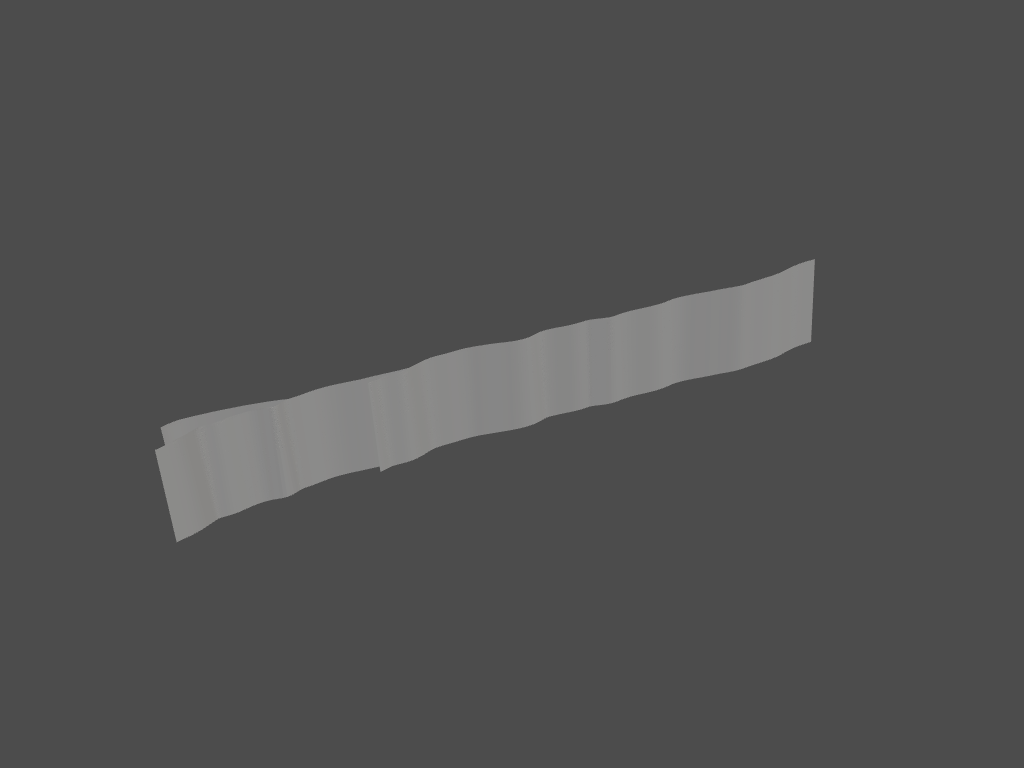

In [7]:
pl = pv.Plotter()
pl.add_mesh(TrialFaultMesh)
pl.show(jupyter_backend="static")

# Get a local reference frame cell-wise to proyect the stress

So basically get the normal $\boldsymbol{n}$, and use the depth direction $\boldsymbol{z}$ to calculate the strike direction $\boldsymbol{t_s}$ and then the dip direction $\boldsymbol{t_d}$

$$\boldsymbol{t_s} = \boldsymbol{n} \times \boldsymbol{z}$$
$$\boldsymbol{t_d} = \boldsymbol{t_s} \times \boldsymbol{n}$$

it will not necessarily be consistent throughout the mesh in the case of a miscalculated normal (pointing towards another direction than the general trend), but I only care about the norm of the ratio between shear stress in a given direction and the normal stress.

In [8]:
def compute_mesh_normals(coord, cells):
    """ Function the normal vectors

    Function 'compute_mesh_normals' computes normals at cells, and at points weighted by the
    area of the surrounding cells on a triangular mesh.

    Args:
        coords (array): np.ndarray(n, k) List of n k-dimensional coordinate points
        cells (array): np.ndarray(m, 3) Triangular cell connectivity

    Returns:
        point_nvecs (array): np.ndarray(n, k) List of k-dimensional normal vector at the n points
    """

    cell_vecs = np.diff(coord[cells], axis=1)
    cell_nvecs = np.cross(-cell_vecs[:, 0, :], cell_vecs[:, 1, :]) / 2.

    cell_sp = csr_matrix((np.ones(cells.shape[0]*3),
                         cells.flat, np.arange(0, 3*cells.shape[0]+1, 3)),
                         shape=(cells.shape[0],
                         coord.shape[0]))

    return normalize(cell_nvecs), normalize(cell_sp.T.dot(cell_nvecs) / 3. )

In [9]:
xyz_centers = \
    (TrialFault_xyz[TrialFault_connect[:,0]] + TrialFault_xyz[TrialFault_connect[:,1]] + TrialFault_xyz[TrialFault_connect[:,2]] )/3.
CellNormals,PointNormals = compute_mesh_normals(TrialFault_xyz, TrialFault_connect)

ZDir = np.array([0,0,-1]*np.shape(CellNormals)[0]).reshape(np.shape(CellNormals)[0],np.shape(CellNormals)[1])
TangentStrike = normalize(np.cross(CellNormals, ZDir))
TangentDip = normalize(np.cross(TangentStrike, CellNormals))

### Assign cell-wise each set of fault local reference frame

In [10]:
TrialFaultMesh["Cell-Normals"] = CellNormals
TrialFaultMesh["Cell-TangentStrike"] = TangentStrike
TrialFaultMesh["Cell-TangentDip"] = TangentDip

TrialFaultMesh

UnstructuredGrid (0x7f60ce163b20)
  N Cells:	222811
  N Points:	112221
  X Bounds:	-1.033e+06, -8.966e+05
  Y Bounds:	2.066e+06, 2.116e+06
  Z Bounds:	-1.538e+04, 4.591e+03
  N Arrays:	3

### Sanity check for the cell-wise reference frame

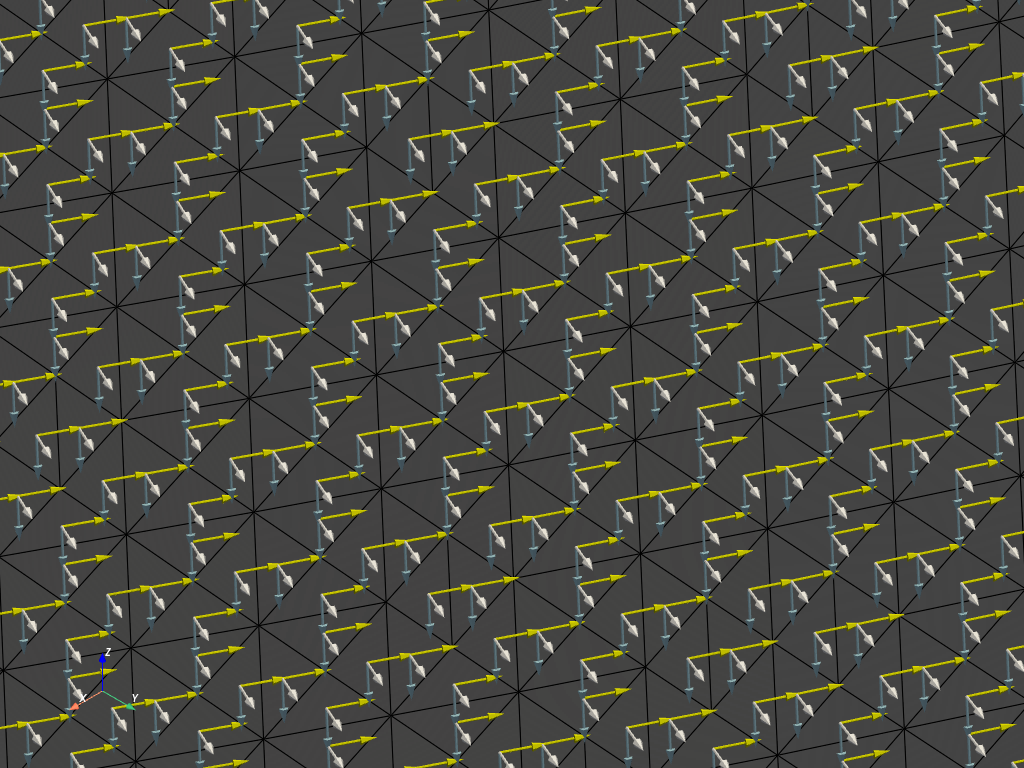

In [11]:
ColorTesting = ["white", "yellow","lightblue"]
FactorVal = 1e2

pl = pv.Plotter()

pl.add_mesh(TrialFaultMesh,color="gray",show_edges=True)

field = "Cell-Normals"
glyphsNormals = TrialFaultMesh.glyph(orient=field, scale=field,factor=FactorVal)
pl.add_mesh(glyphsNormals,color=ColorTesting[0])

field = "Cell-TangentStrike"
glyphsNormals = TrialFaultMesh.glyph(orient=field, scale=field,factor=FactorVal)
pl.add_mesh(glyphsNormals,color=ColorTesting[1])

field = "Cell-TangentDip"
glyphsNormals = TrialFaultMesh.glyph(orient=field, scale=field,factor=FactorVal)
pl.add_mesh(glyphsNormals,color=ColorTesting[2])

_ = pl.add_axes(line_width=1)
pl.camera.zoom(100.0)
pl.show(jupyter_backend="static")

### Apply an optimal stress orientation
Get the 3x3 stress

In [12]:
InversionStress = {"USGS":{'strike': 92, 'dip': 67, 'rake': -40},
                   "GCMT":{'strike': 282,'dip': 83, 'rake': -9}, 
                   "GFZ" :{'strike': 102,'dip': 84, 'rake': -3}, 
                   "CEA" :{'strike': 101,'dip': 87, 'rake': -7} }


OptimalStress = {'strike': 100,'dip': 90, 'rake': 0}
#OptimalStress = InversionStress["GFZ"]

StressPerCellList = np.array([TibetOptimalStressWrap(z = iz, **OptimalStress) for iz in xyz_centers[:,2]]) #~8.1s for all cells

### Project onto the fault to get cell tractions
$$\boldsymbol{\tau}_{td}=\boldsymbol{n}\cdot \boldsymbol{\hat{\sigma}}\cdot \boldsymbol{t}_{td}$$
$$\boldsymbol{\tau}_{ts}=\boldsymbol{n}\cdot \boldsymbol{\hat{\sigma}}\cdot \boldsymbol{t}_{ts}$$
$$\boldsymbol{\sigma}_{n}=\boldsymbol{n}\cdot \boldsymbol{\hat{\sigma}}\cdot \boldsymbol{n}$$

In [13]:
# Define the operator of vector-Matrix-vector multiplication per element in a list
Operator_vMu = lambda v, M, u:  np.einsum('ij,ij->i', np.einsum('ij,ijk->ik',v,np.array([mi.reshape(3,3) for mi in M])), u)

# Apply and store the tractions and normal stress
TrialFaultMesh["S_n"] = S_n = Operator_vMu(TrialFaultMesh["Cell-Normals"], StressPerCellList, TrialFaultMesh["Cell-Normals"]) 
TrialFaultMesh["S_s"] = S_s = Operator_vMu(TrialFaultMesh["Cell-Normals"], StressPerCellList, TrialFaultMesh["Cell-TangentStrike"])
TrialFaultMesh["S_d"] = S_d = Operator_vMu(TrialFaultMesh["Cell-Normals"], StressPerCellList, TrialFaultMesh["Cell-TangentDip"])

TrialFaultMesh["S_d/S_n"] = np.abs(S_d/S_n)
TrialFaultMesh["S_s/S_n"] = np.abs(S_s/S_n)

### Visualize result

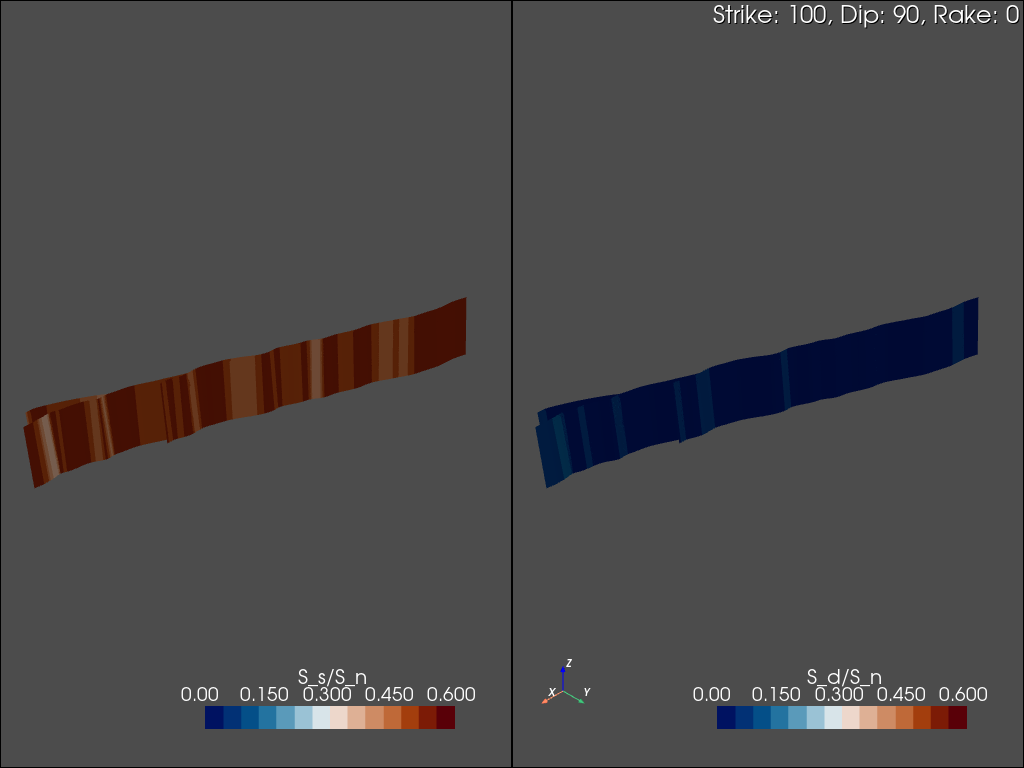

In [14]:
pl = pv.Plotter(shape=(1, 2))
cscale = [0,.6]

pl.add_mesh(TrialFaultMesh,scalars="S_s/S_n", clim=cscale, cmap = Cmap)

pl.subplot(0, 1)
pl.add_mesh(TrialFaultMesh.copy(),scalars="S_d/S_n", clim=cscale, cmap = Cmap)



##################################################################################################################
_ = pl.add_axes(line_width=1)
actor = pl.add_text("Strike: {}, Dip: {}, Rake: {}".format(OptimalStress['strike'],OptimalStress['dip'], OptimalStress['rake']),
                     position='upper_right', color='white', shadow=True, font_size=14)

OutFolderPath='/home/nico/Documents/Extra/Programming/EQ_modeling_Scripts/Qinghai/Output/HomogeneousStress/' + \
              'HomogeneousStressTEST-{}-{}-{}.png'.format(OptimalStress['strike'],OptimalStress['dip'], OptimalStress['rake'])

pl.show(jupyter_backend="static")


# Iteration over a selection of homogeneous stress choices
### Define the stress calculation and projection as a function of strike, dip, rake

In [15]:
def StressProjection(strike, dip, rake):
    OptimalStress = {'strike': strike,'dip': dip, 'rake': rake}
    cscale = [0,.6]

    StressPerCellList = np.array([TibetOptimalStressWrap(z = iz, **OptimalStress) for iz in xyz_centers[:,2]])

    TrialFaultMesh["S_n" ] = S_n  = Operator_vMu(TrialFaultMesh["Cell-Normals"], StressPerCellList, TrialFaultMesh["Cell-Normals"]) 
    TrialFaultMesh["S_s"] = S_s = Operator_vMu(TrialFaultMesh["Cell-Normals"], StressPerCellList, TrialFaultMesh["Cell-TangentStrike"])
    TrialFaultMesh["S_d"] = S_d = Operator_vMu(TrialFaultMesh["Cell-Normals"], StressPerCellList, TrialFaultMesh["Cell-TangentDip"])

    TrialFaultMesh["S_d/S_n"] = np.abs(S_d/S_n)
    TrialFaultMesh["S_s/S_n"] = np.abs(S_s/S_n)

    pl = pv.Plotter(shape=(1, 2),off_screen=True)

    pl.add_mesh(TrialFaultMesh,scalars="S_s/S_n", clim=cscale, cmap = Cmap)
    pl.subplot(0, 1)
    pl.add_mesh(TrialFaultMesh.copy(),scalars="S_d/S_n", clim=cscale, cmap = Cmap)
    ##################################################################################################################
    _ = pl.add_axes(line_width=1)
    actor = pl.add_text("Strike: {}, Dip: {}, Rake: {}".format(OptimalStress['strike'],OptimalStress['dip'], OptimalStress['rake']),
                        position='upper_right', color='white', shadow=True, font_size=14)


    OutFolderPath='/home/nico/Documents/Extra/Programming/EQ_modeling_Scripts/Qinghai/Output/HomogeneousStress/' + \
                'HomogeneousStress-{}-{}-{}.png'.format(OptimalStress['strike'],OptimalStress['dip'], OptimalStress['rake'])


    pl.screenshot(OutFolderPath)
    pl.close(render=False)

### Iteration over the stress choices
First the combination of all the input parameters

In [16]:
from itertools import product

strikeList = np.arange(130,131,10)
#strikeList = np.arange(290,301,10)
dipList = np.arange(60,91,10)
rakeList = np.arange(0,-35,-10)

InputStrikeDipRake = list(product(strikeList, dipList, rakeList))

np.shape(InputStrikeDipRake)

(16, 3)

And finally call the function with the input parameters combinations

In [17]:
nSDR = np.shape(InputStrikeDipRake)[0]
[StressProjection(*InputStrikeDipRake[iSDR]) for iSDR in progressbar(range(nSDR), "Computing: ")]


Computing: [############################################################] 16/16



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]